[Source](https://colab.research.google.com/drive/1BiQiw31DT7-cDp1-0ySXvvhzqomTdI-o?usp=sharing&pli=1&authuser=5#scrollTo=_kbS7nRxcMt7)

In [1]:
# !pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
# !pip install -q datasets bitsandbytes einops wandb

In [9]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd 

In [3]:
import torch
from transformers import  AutoTokenizer
from transformers import AutoModelForCausalLM, AutoConfig

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

device = 'cuda:0'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    
)

model_name = "microsoft/phi-2"

phi2_model_pretrained = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,  
    quantization_config=bnb_config,
    device_map={"":0}
#     torch_dtype = torch.float16
)

# phi2_model_pretrained.to(device)
phi2_model_pretrained.config.use_cache = False

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.bos_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResBlock(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.pre_norm = nn.LayerNorm(input_size)
        self.proj = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.GELU(),
            nn.Linear(input_size, input_size)
        )
    def forward(self, x):
        x = self.pre_norm(x)
        return x + self.proj(x)
    
class Phi2wrapper(nn.Module):
    
    #This defines the structure of the NN.
    def __init__(self, input_dim_CLIP=768, input_dim_phi2=2560, 
                 phi2_model=phi2_model_pretrained, 
                tokenizer=tokenizer, teacher_forcing = 3, device=device):
        
        super(Phi2wrapper, self).__init__()

        self.input_dim_CLIP = input_dim_CLIP
        self.input_dim_phi2 = input_dim_phi2
        self.projection_img = nn.Linear(self.input_dim_CLIP, self.input_dim_phi2, 
                                        bias=False)
                                                                                                                                                           
        self.resblock = SimpleResBlock(self.input_dim_phi2)
        self.phi2_model = phi2_model
        self.max_token_len_data = max_token_len_data
        self.tokenizer = tokenizer

        self.device = device
        self.teacher_forcing = teacher_forcing

        bos = self.tokenizer("Image: ", return_tensors="pt", return_attention_mask=False)
        eoi = self.tokenizer(" Question: ", return_tensors="pt", return_attention_mask=False)
    
        self.bos_embedding = self.phi2_model.get_input_embeddings()(bos.input_ids.to(self.device)).squeeze(0)
        self.eoi_embedding = self.phi2_model.get_input_embeddings()(eoi.input_ids.to(self.device)).squeeze(0)
        
        self.eos_embedding = self.phi2_model.get_input_embeddings()(torch.tensor(self.tokenizer.eos_token_id).to(self.device)).unsqueeze(0)

    def forward(self, x, input_q, target_a):

        x = self.projection_img(x)
        x = self.resblock(x)

        batch_size = x.shape[0]
        
        input_q_embedding = self.phi2_model.get_input_embeddings()(input_q)
        
        x = torch.cat((self.bos_embedding.repeat(batch_size,1,1), x, 
                    self.eoi_embedding.repeat(batch_size,1,1), input_q_embedding), dim=1)
        
        loss = 0 
        word_output_pred_tokens = None

        for idx in range(target_a.shape[1]): 
            
            out_phi = self.phi2_model.model.layers[0](x.to(torch.float16))
            
            for layer_idx in range(1, 32): 
                out_phi = self.phi2_model.model.layers[layer_idx](out_phi[0])
                
            out_phi = self.phi2_model.model.final_layernorm(out_phi[0])
            out_phi = self.phi2_model.lm_head(zzout_phi) ## torch.Size([batch, 55, 50297])
            
            next_word = torch.argmax(out_phi[:, -1, :], dim=-1) ## [batch]
            
            caption_word_token = input_caption[:,idx]

            
            no_of_pad_tokens = sum(torch.eq(torch.tensor([self.tokenizer.pad_token_id]*batch_size).to(self.device), caption_word_token))
            
            if no_of_pad_tokens == torch.tensor(batch_size): 
                break 
                
            if idx>=self.teacher_forcing:
#                 print(idx, " next word model", self.tokenizer.decode(next_word))
                caption_word_embedding = self.phi2_model.get_input_embeddings()(next_word).unsqueeze(1)
            else:
#                 print(idx, " next word ground truth", self.tokenizer.decode(caption_word_token))
                caption_word_embedding = self.phi2_model.get_input_embeddings()(caption_word_token).unsqueeze(1)
            
            ## instead of append like instruct image output words.. instruct image w1 out, instruct image w2 output ..
            x = torch.cat((x, caption_word_embedding), dim=1)
            
            loss_val = F.cross_entropy(out_phi[:, -1, :], caption_word_token, 
                        ignore_index=self.tokenizer.pad_token_id)
            
            loss += loss_val
            
            if word_output_pred_tokens is None: 
                word_output_pred_tokens = next_word.unsqueeze(1) 
            else:

                word_output_pred_tokens = torch.cat((word_output_pred_tokens, next_word.unsqueeze(1)), dim=1)
        
        return loss/idx, word_output_pred_tokens


torch.set_grad_enabled(True)  
phi2_projection_model = Phi2wrapper().to(device=device)

In [5]:
# load projection_img, resblock from stage 1 
phi2_projection_model.projection_img.load_state_dict(torch.load('/media/App/amaranth/lavanya/Capstone_data/weights/p1_epoch_1_iteration_5906.pth'))
phi2_projection_model.resblock.load_state_dict(torch.load('/media/App/amaranth/lavanya/Capstone_data/weights/p2_epoch_1_iteration_5906.pth'))

<All keys matched successfully>

In [6]:
# ###### DATASET 
# import json 

# llava_json_fname = '/media/App/amaranth/lavanya/Capstone_data/llava_instruct_150k.json'

# # Opening JSON file
# f = open(llava_json_fname)
 
# # returns JSON object as 
# # a dictionary
# llava_json = json.load(f)
 
# # Closing file
# f.close()

In [7]:
# import pandas as pd 

# llava_json_df  = []

# for l_entry in llava_json:
#     img_id = l_entry['id']
#     conversations = l_entry['conversations']
#     len_conv = len(conversations)
    
#     ## the first one is human, the second one is gpt 
#     for idx in range(0, len_conv, 2): 
#         Q_human = conversations[idx]['value'].replace('<image>', '').replace('\n', '')
#         A_GPT = conversations[idx+1]['value']
#         llava_json_df.append([img_id, Q_human, A_GPT])
        
# #         if conversations[idx]['from'] != 'human': 
# #             print(conversations[idx])
# #         if conversations[idx+1]['from'] != 'gpt': 
# #             print(conversations[idx+1])

# llava_json_df = pd.DataFrame(data=llava_json_df, columns = ['image_id', 'Q_human', 'A_GPT'])

In [ ]:
# def get_tokens_text(img_caption): 
#     img_caption_tokenized = tokenizer(img_caption, return_tensors="pt", 
#                                                return_attention_mask=False).input_ids.squeeze(0).tolist()
#     return img_caption_tokenized
                                           
# llava_json_df['Q_human_tokenized'] = llava_json_df['Q_human'].apply(lambda x: get_tokens_text(x))
# llava_json_df['A_GPT_tokenized'] = llava_json_df['A_GPT'].apply(lambda x: get_tokens_text(x))

In [ ]:
# llava_json_df.to_csv('/media/App/amaranth/lavanya/Capstone_data/llava_instruct_150k_df.csv')

In [11]:
llava_json_df = pd.read_csv('/media/App/amaranth/lavanya/Capstone_data/llava_instruct_150k_df.csv')
llava_json_df.head()

,Unnamed: 0,image_id,Q_human,A_GPT,Q_human_tokenized,A_GPT_tokenized
0,0,33471,What are the colors of the bus in the image?,The bus in the image is white and red.,"[2061, 389, 262, 7577, 286, 262, 1323, 287, 26...","[464, 1323, 287, 262, 2939, 318, 2330, 290, 22..."
1,1,33471,What feature can be seen on the back of the bus?,The back of the bus features an advertisement.,"[2061, 3895, 460, 307, 1775, 319, 262, 736, 28...","[464, 736, 286, 262, 1323, 3033, 281, 15422, 13]"
2,2,33471,Is the bus driving down the street or pulled o...,"The bus is driving down the street, which is c...","[3792, 262, 1323, 5059, 866, 262, 4675, 393, 5...","[464, 1323, 318, 5059, 866, 262, 4675, 11, 543..."
3,3,52846,Where is the cat positioned in the image?,The cat is positioned on top of the back of th...,"[8496, 318, 262, 3797, 19378, 287, 262, 2939, 30]","[464, 3797, 318, 19378, 319, 1353, 286, 262, 7..."
4,4,52846,What is the cat doing in the image?,The cat is coming out from some curtains onto ...,"[2061, 318, 262, 3797, 1804, 287, 262, 2939, 30]","[464, 3797, 318, 2406, 503, 422, 617, 41160, 4..."


In [34]:
import ast

llava_json_df['len_token_q'] = llava_json_df['Q_human_tokenized'].apply(lambda x: len(ast.literal_eval(x)))
llava_json_df['len_token_a'] = llava_json_df['A_GPT_tokenized'].apply(lambda x: len(ast.literal_eval(x)))

In [35]:
max(llava_json_df['len_token_q']), max(llava_json_df['len_token_a'])

(55, 637)

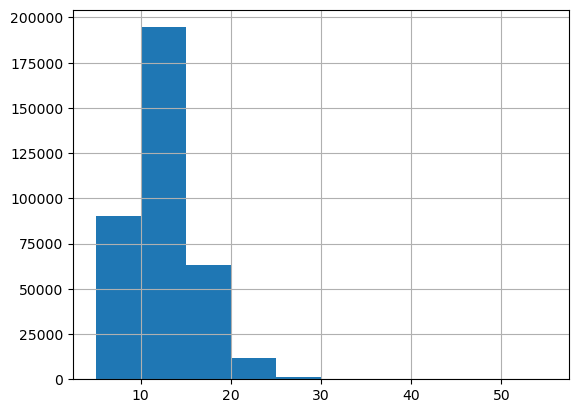

In [38]:
hist = llava_json_df['len_token_q'].hist()

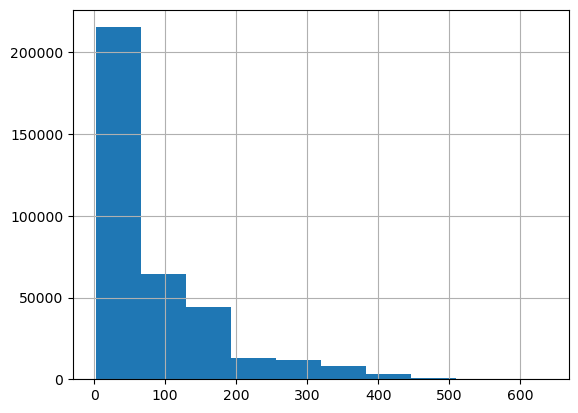

In [39]:
hist = llava_json_df['len_token_a'].hist()

In [40]:
max_token_len_q = 30 
max_token_len_a = 500

In [41]:
llava_data_subset = llava_json_df[(llava_json_df['len_token_q'] <= max_token_len_q) & \
                                 (llava_json_df['len_token_a'] <= max_token_len_a)]
len(llava_data_subset)

361062

In [43]:
###### DATASET

from torch.utils.data import Dataset, DataLoader
import pandas as pd 
import json
import os 
import h5py

import h5py    
import numpy as np    

class LLAVA_150k_Dataset_Instruct(Dataset):

    def __init__(
        self, embedding_path, llava_json_df, 
        tokenizer=tokenizer, max_token_len_q=max_token_len_q, max_token_len_a=max_token_len_a):
        
        self.embedding_path = embedding_path
        self.llava_json_df = llava_json_df
        
        self.tokenizer = tokenizer
        self.max_token_len_q = max_token_len_q
        self.max_token_len_a = max_token_len_a

    def __len__(self):
        return len(self.llava_json_df)
    
    def __getitem__(self, index):

        row = self.llava_json_df.iloc[[index]]

        df_img = row['image_id'].values[0]
        img_base_name = '0'*(12-len(str(df_img))) + str(df_img)
        img_base_name = img_base_name.replace(' ', '0')
        img_clip_embedding_path = os.path.join(self.embedding_path, f'{img_base_name}.h5')

        np_array_embed_img = h5py.File(img_clip_embedding_path,'r+')['image_features'][()]
        
        Q_human_tokenized = ast.literal_eval(row['Q_human_tokenized'].values[0])
        A_gpt_tokenized = ast.literal_eval(row['A_GPT_tokenized'].values[0])
        
        if len(Q_human_tokenized) != self.max_token_len_q: 
            pad_q_len = self.max_token_len_q - len(Q_human_tokenized)
            Q_human_tokenized = Q_human_tokenized + [self.tokenizer.pad_token_id]*pad_q_len
        
        if len(A_gpt_tokenized) != self.max_token_len_a: 
            pad_a_len = self.max_token_len_a - len(A_gpt_tokenized)
            A_gpt_tokenized = A_gpt_tokenized + [self.tokenizer.pad_token_id]*pad_a_len
        
        return (torch.tensor(np_array_embed_img).squeeze(0), torch.tensor(Q_human_tokenized)), torch.tensor(A_gpt_tokenized)


dataset = LLAVA_150k_Dataset_Instruct('/media/App/amaranth/lavanya/Capstone_data/clip_features_base_patch32/', 
                            llava_data_subset)

In [44]:
(x1, x2), y = dataset[0]

In [45]:
x1.shape, x2.shape, y.shape

(torch.Size([49, 768]), torch.Size([30]), torch.Size([500]))

In [ ]:
df = dataset.to_pandas()

def preprocess_data(df):
    df_assistant = df[(df.role == "assistant") & (df["rank"] == 0.0)].copy()
    df_assistant["output"] = df_assistant["text"].values

    df_prompter = df[(df.role == "prompter")].copy()
    df_prompter = df_prompter.set_index("message_id")

    inputs = []
    parent_ids = []

    for _, row in df_assistant.iterrows():
        input = df_prompter.loc[row.parent_id]

        inputs.append(input.text)
        parent_ids.append(input.parent_id)

    df_assistant["instruction"] = inputs
    df_assistant["parent_id"] = parent_ids

    df_assistant = df_assistant[df_assistant.lang == "en"]

    df_assistant = df_assistant[
        ["instruction", "output", "message_id", "parent_id"]
    ].rename(
        columns={"message_id": "id"}
    )

    return df_assistant

dataset_preprocessed = preprocess_data(df)

In [ ]:
dataset_preprocessed.instruction.iloc[0]

In [ ]:
from peft import LoraConfig

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "Wqkv",
        "out_proj",
        "fc1",
        "fc2",
    ]
)

In [ ]:
from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 2
gradient_accumulation_steps = 8
optim = "paged_adamw_32bit"
save_steps = 100
logging_steps = 10
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 500
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    # gradient_checkpointing=True,
)

In [ ]:
from datasets import Dataset
dataset_new = Dataset.from_pandas(dataset_preprocessed)
dataset = dataset_new.map(lambda data: {'text': 
[f'[INST] ' + prompt + ' [/INST] ' + response for prompt, response in zip(data['instruction'], data['output'])]}, 
                          batched=True)

In [ ]:
from trl import SFTTrainer

max_seq_length = 256

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

In [ ]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

In [ ]:
trainer.train()

In [ ]:
from transformers import pipeline

In [ ]:
# Run text generation pipeline with our next model
prompt = "What is a large language model?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [ ]:
new_model = "phi-2-custom"
trainer.model.save_pretrained(new_model)